In this notebook, we will run an experiment to display the average perturbation effect values that we generate with the 4 different methods we have for perturbation effect generation (other than the method for generating the perturbation effect values, we will be holding everything else the same). 

Recall that we have 4 methods for generating perturbation effect data (see `generate_in_silico_data.ipynb` for more information on these):
1. No Mean Adjustment
2. Standard Mean Adjustment
3. Mean adjustment dependent on all TFs bound to gene in question
4. Mean adjustment dependent on binary relationships between bound and unbound TFs to gene in question.

After understanding what the generated data looks like for each of these methods, we will perform another experiment where we train the same model on data generated with each of these methods and compare the model's performance to a simple linear model.

In [38]:
# imports
from yeastdnnexplorer.probability_models.generate_data import (generate_gene_population, 
                                                               generate_binding_effects,
                                                               generate_pvalues,
                                                               generate_perturbation_effects)

import torch
import matplotlib.pyplot as plt

from yeastdnnexplorer.probability_models.relation_classes import Relation, And, Or
from yeastdnnexplorer.probability_models.generate_data import (
    default_perturbation_effect_adjustment_function,
    perturbation_effect_adjustment_function_with_tf_relationships,
    perturbation_effect_adjustment_function_with_tf_relationships_boolean_logic
)

from pytorch_lightning import Trainer, LightningModule, seed_everything
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import CSVLogger, TensorBoardLogger
from torchsummary import summary

from yeastdnnexplorer.data_loaders.synthetic_data_loader import SyntheticDataLoader
from yeastdnnexplorer.ml_models.simple_model import SimpleModel
from yeastdnnexplorer.ml_models.customizable_model import CustomizableModel

torch.manual_seed(42)  # For CPU
torch.cuda.manual_seed_all(42)  # For all CUDA devices

Generating the binding data will be the same as always, see `generate_in_silico_data.ipynb`

In [39]:
n_genes = 3000

bound = [0.5, 0.5, 0.5, 0.5, 0.5]
n_sample = [1, 1, 2, 2, 4]

# this will be a list of length 10 with a GenePopulation object in each element
gene_populations_list = []
for bound_proportion, n_draws in zip(bound, n_sample):
    for _ in range(n_draws):
        gene_populations_list.append(generate_gene_population(n_genes, bound_proportion))
        
# Generate binding data for each gene population
binding_effect_list = [generate_binding_effects(gene_population)
                     for gene_population in gene_populations_list]

# Calculate p-values for binding data
binding_pvalue_list = [generate_pvalues(binding_data) for binding_data in binding_effect_list]

binding_data_combined = [torch.stack((gene_population.labels, binding_effect, binding_pval), dim=1)
                         for gene_population, binding_effect, binding_pval
                         in zip (gene_populations_list, binding_effect_list, binding_pvalue_list)]

# Stack along a new dimension (dim=1) to create a tensor of shape [num_genes, num_TFs, 3]
binding_data_tensor = torch.stack(binding_data_combined, dim=1)

Now we define our experiment, this function will return the average perturbation effects (across n_iterations iterations) for each TF for a specific gene for each of the 4 data generation method we have at our disposal. Due to the randomness in the generated data, we need to find the averages over a number of iterations to get the true common values.

We also need to define dictionaries of TF relationships for our third and fourth methods of generating perturbation data, see `generate_in_silico_data.ipynb` for an explanation of what these represent and how they are used / structured. The documentation in `generate_data.py` may be helpful as well.

In [40]:
tf_relationships = {
    0: [1],
    1: [8],
    2: [5, 6],
    3: [4],
    4: [5],
    5: [9],
    6: [4],
    7: [1, 4],
    8: [6],
    9: [4],
}

tf_relationships_dict_boolean_logic = {
    0: [And(3, 4, 8), Or(3, 7), Or(1, 1)],
    1: [And(5, Or(7, 8))],
    2: [],
    3: [Or(7, 9), And(6, 7)],
    4: [And(1, 2)],
    5: [Or(0, 1, 2, 8, 9)],
    6: [And(0, Or(1, 2))],
    7: [Or(2, And(5, 6, 9))],
    8: [],
    9: [And(6, And(3, Or(0, 9)))],
}

def experiment(n_iterations = 10, GENE_IDX = 0):
    print("Bound (1) and Unbound (0) Labels for gene " + str(GENE_IDX) + ":")
    print(binding_data_tensor[GENE_IDX, :, 0])

    num_tfs = sum(n_sample)
    
    no_mean_adjustment_scores = torch.zeros(num_tfs)
    normal_mean_adjustment_scores = torch.zeros(num_tfs)
    dep_mean_adjustment_scores = torch.zeros(num_tfs)
    boolean_logic_scores = torch.zeros(num_tfs)

    # we generate perturbation effects for each TF on each iteration and then add them to the running totals
    for i in range(n_iterations):
        # Method 1: Generate perturbation effects without mean adjustment
        perturbation_effects_list_no_mean_adjustment = [generate_perturbation_effects(binding_data_tensor[:, tf_index, :].unsqueeze(1), tf_index=0) 
                                                        for tf_index in range(sum(n_sample))]
        perturbation_effects_list_no_mean_adjustment = torch.stack(perturbation_effects_list_no_mean_adjustment, dim=1)

        # Method 2: Generate perturbation effects with normal mean adjustment
        perturbation_effects_list_normal_mean_adjustment = generate_perturbation_effects(
            binding_data_tensor, 
            max_mean_adjustment=10.0
        )

        # Method 3: Generate perturbation effects with dependent mean adjustment
        perturbation_effects_list_dep_mean_adjustment = generate_perturbation_effects(
            binding_data_tensor, 
            tf_relationships=tf_relationships,
            adjustment_function=perturbation_effect_adjustment_function_with_tf_relationships,
            max_mean_adjustment=10.0,
        )
        
        # Method 4: Generate perturbation effects with binary relations between the TFs
        perturbation_effects_list_boolean_logic = generate_perturbation_effects(
            binding_data_tensor, 
            adjustment_function=perturbation_effect_adjustment_function_with_tf_relationships_boolean_logic,
            tf_relationships=tf_relationships_dict_boolean_logic,
            max_mean_adjustment=10.0,
        )

        # take absolute values since we only care about the magnitude of the effects
        no_mean_adjustment_scores += abs(perturbation_effects_list_no_mean_adjustment[GENE_IDX, :])
        normal_mean_adjustment_scores += abs(perturbation_effects_list_normal_mean_adjustment[GENE_IDX, :])
        dep_mean_adjustment_scores += abs(perturbation_effects_list_dep_mean_adjustment[GENE_IDX, :])
        boolean_logic_scores += abs(perturbation_effects_list_boolean_logic[GENE_IDX, :])

        if (i + 1) % 5 == 0:
            print(f"iteration {i+1} completed")
        
    # divide by the number of iterations to get the averages
    no_mean_adjustment_scores /= n_iterations
    normal_mean_adjustment_scores /= n_iterations
    dep_mean_adjustment_scores /= n_iterations
    boolean_logic_scores /= n_iterations
    
    return no_mean_adjustment_scores, normal_mean_adjustment_scores, dep_mean_adjustment_scores, boolean_logic_scores

Now we can run the experiment for n_iterations, I find that you should iterate at least 30 times, but closer to 100 is most ideal. This could take 1-5 minutes depending on your computer.

In [41]:
GENE_IDX = 0
experiment_results = experiment(n_iterations=50, GENE_IDX=GENE_IDX)

Bound (1) and Unbound (0) Labels for gene 0:
tensor([0., 0., 0., 1., 1., 1., 1., 1., 0., 1.])
iteration 5 completed
iteration 10 completed
iteration 15 completed
iteration 20 completed
iteration 25 completed
iteration 30 completed
iteration 35 completed
iteration 40 completed
iteration 45 completed
iteration 50 completed


We now plot our results.

Bound (bound) TFs for gene 0 are: [3, 4, 5, 6, 7, 9]
Unbound (unbound) TFs for gene 0 are: [0, 1, 2, 8]
tensor([0., 0., 0., 1., 1., 1., 1., 1., 0., 1.])


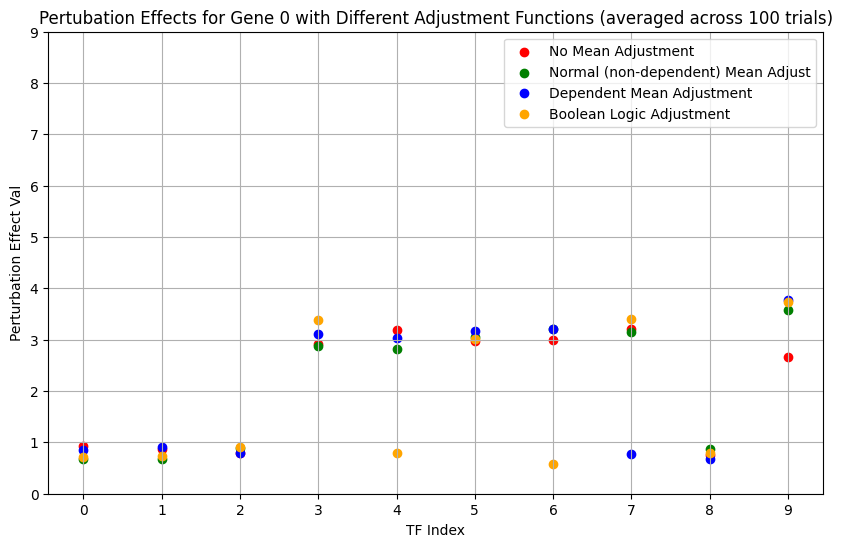

In [42]:
x_vals = list(range(sum(n_sample)))
print("Bound (bound) TFs for gene " + str(GENE_IDX) + " are: " + str(binding_data_tensor[GENE_IDX, :, 0].nonzero().flatten().tolist()))
print("Unbound (unbound) TFs for gene " + str(GENE_IDX) + " are: " + str((1 - binding_data_tensor[GENE_IDX, :, 0]).nonzero().flatten().tolist()))
print(binding_data_tensor[GENE_IDX, :, 0])
plt.figure(figsize=(10, 6))

# Plot each set of experiment results with a different color
colors = ['red', 'green', 'blue', 'orange']
for index, results in enumerate(experiment_results):
    plt.scatter(x_vals, results, color=colors[index])

plt.title('Pertubation Effects for Gene ' + str(GENE_IDX) + ' with Different Adjustment Functions (averaged across 100 trials)')
plt.xlabel('TF Index')
plt.ylabel('Perturbation Effect Val')

#added to compare this to previous graph, REMOVE LATER
plt.ylim(0,9)


plt.xticks(x_vals)
plt.grid(True)
plt.legend(['No Mean Adjustment', 'Normal (non-dependent) Mean Adjust', 'Dependent Mean Adjustment', 'Boolean Logic Adjustment'])
plt.show()

Recall that for the dependent mean adjustment, the TF in question must be bound and all of the TFs in its dependency array (in the tf_relationships dictionary) must be bound as well. This is why we do not adjust the mean for TF 7 despite it being bound, it depends on TF 1 and TF 4 both being bound, and TF1 is not bound.

Similarly, for the boolean logic adjustment, we do not adjust the mean for 6 despite it being bound because it depends on (TF0 && (TF1 || TF2)) being bound, and none of those 3 TFs are bound to the gene we are studying.

Note that if you change GENE_IDX, the random seed, or any of the relationship dictionaris that this explanation will no longer apply to the data you are seeing in the plot.

## Training models on data generated from the 4 different methods
In the next experiment, we will be training the exact same model on data generated from each of these 4 methods. We will also train a simple linear model on all four methods to use as a baseline to compare to. Other than the method used to generate the data, everything else will be held the same.

In [6]:
# define checkpoints and loggers
best_model_checkpoint = ModelCheckpoint(
    monitor="val_explained_variance",
    mode="min",
    filename="best-model-{epoch:02d}-{val_loss:.2f}",
    save_top_k=1,
)

# Callback to save checkpoints every 5 epochs, regardless of performance
periodic_checkpoint = ModelCheckpoint(
    filename="periodic-{epoch:02d}",
    every_n_epochs=2,
    save_top_k=-1,  # Setting -1 saves all checkpoints
)

# define loggers for the model
tb_logger = TensorBoardLogger("logs/tensorboard_logs")
csv_logger = CSVLogger("logs/csv_logs")

We define a few helper functions to run our experiment. We make helper functions for things that will mostly be the same across each training loop so that we don't have to keep redefining them.

In [7]:
def get_data_module(max_mean_adjustment, adjustment_function = default_perturbation_effect_adjustment_function, tf_relationships_dict = {}):
    return SyntheticDataLoader(
        batch_size=32,
        num_genes=4000,
        bound_mean=3.0,
        bound=[0.5] * 5,
        n_sample=[1, 1, 2, 2, 4],  # sum of this is num of tfs
        val_size=0.1,
        test_size=0.1,
        random_state=42,
        max_mean_adjustment=max_mean_adjustment,
        adjustment_function=adjustment_function,
        tf_relationships=tf_relationships_dict,
    )

def get_model(num_tfs):
    return CustomizableModel(
        input_dim=num_tfs,
        output_dim=num_tfs,
        lr=0.01,
        hidden_layer_num=2,
        hidden_layer_sizes=[64, 32],
        activation="LeakyReLU",
        optimizer="RMSprop",
        L2_regularization_term=0.0,
        dropout_rate=0.0,
    )

def get_linear_model(num_tfs):
    return SimpleModel(
        input_dim=num_tfs,
        output_dim=num_tfs,
        lr=0.01
    )

def get_trainer():
    # uncomment callbacks or logggers if you would like checkpoints / logs
    return Trainer(
        max_epochs=10,
        deterministic=True,
        accelerator="cpu",
        # callbacks=[best_model_checkpoint, periodic_checkpoint],
        # logger=[tb_logger, csv_logger],
    )

In [8]:
# These lists will store the test results for different models and data generation methods
model_ves = []
linear_model_test_ves = []

In [30]:
import torch
from sklearn.metrics import explained_variance_score

data_module = get_data_module(0.0)
num_tfs = sum(data_module.n_sample)
model_ves = []  # List to store explained variance for the non-linear model
linear_model_test_ves = [] # List to store explained variance for the linear model

def calculate_explained_variance(test_results, data_module, model):
    predictions = []
    targets = []

    model.eval()  # Set the model to evaluation mode

    with torch.no_grad():  # Disable gradient calculation
        for batch in data_module.test_dataloader():
             # Assuming your data is in the format (x, y)
            x, y = batch
            outputs = model(x)
            predictions.append(outputs)
            targets.append(y)
    mse = torch.nn.functional.mse_loss(torch.tensor(predictions), torch.tensor(targets)).item()
    var_y = torch.var(torch.tensor(targets)).item() 
    explained_variance = 1 - (mse / var_y)
    return explained_variance 

# # Function to calculate explained variance from test results
# def calculate_explained_variance(test_results, data_module, model):
#     """
#     Calculates the explained variance score using PyTorch and scikit-learn.

#     Args:
#         test_results: The results dictionary from the trainer.test() function.
#         data_module: The data module containing the test dataloader.
#         model: The trained PyTorch model.

#     Returns:
#         float: The explained variance score.
#     """
#     predictions = []
#     targets = []

#     model.eval()  # Set the model to evaluation mode

#     with torch.no_grad():  # Disable gradient calculation
#         for batch in data_module.test_dataloader():
#             # Assuming your data is in the format (x, y)
#             x, y = batch
#             outputs = model(x)
#             predictions.append(outputs)
#             targets.append(y)

#     predictions = torch.cat(predictions, dim=0).numpy()  # Concatenate predictions
#     targets = torch.cat(targets, dim=0).numpy()  # Concatenate targets

#     return explained_variance_score(targets, predictions)

# **Train models on data generated with no mean adjustment**

In [31]:
# --- Nonlinear Model ---
model = get_model(num_tfs)
trainer = get_trainer()
trainer.fit(model, data_module)
test_results = trainer.test(model, datamodule=data_module)
explained_variance = calculate_explained_variance(test_results, data_module, model)
model_ves.append(explained_variance)  # Append explained variance to the list
print("Printing test results...")
print(test_results)
print("Printing explained variance")
print(explained_variance)


# --- Linear Model ---
linear_model = get_linear_model(num_tfs)
trainer = get_trainer()
trainer.fit(linear_model, data_module)
test_results = trainer.test(linear_model, datamodule=data_module)
explained_variance = calculate_explained_variance(test_results, data_module, linear_model)
linear_model_test_ves.append(explained_variance)  # Append explained variance to the list
print("Printing linear model test results")
print(test_results)
print("Printing linear model explained variance")
print(explained_variance)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type              | Params
----------------------------------------------------
0 | activation    | LeakyReLU         | 0     
1 | input_layer   | Linear            | 704   
2 | hidden_layers | ModuleList        | 2.1 K 
3 | output_layer  | Linear            | 330   
4 | dropout       | Dropout           | 0     
5 | mae           | MeanAbsoluteError | 0     
6 | SMSE          | SMSE              | 0     
----------------------------------------------------
3.1 K     Trainable params
0         Non-trainable params
3.1 K     Total params
0.012     Total estimated model params size (MB)


Sanity Checking: |                                                                   | 0/? [00:00<?, ?it/s]

Training: |                                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                                        | 0/? [00:00<?, ?it/s]

Validation: |                                                                        | 0/? [00:00<?, ?it/s]

Validation: |                                                                        | 0/? [00:00<?, ?it/s]

Validation: |                                                                        | 0/? [00:00<?, ?it/s]

Validation: |                                                                        | 0/? [00:00<?, ?it/s]

Validation: |                                                                        | 0/? [00:00<?, ?it/s]

Validation: |                                                                        | 0/? [00:00<?, ?it/s]

Validation: |                                                                        | 0/? [00:00<?, ?it/s]

Validation: |                                                                        | 0/? [00:00<?, ?it/s]

Validation: |                                                                        | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


Testing: |                                                                           | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_mae            0.9468895792961121
        test_mse            1.4063981771469116
        test_smse            7.546271800994873
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


ValueError: only one element tensors can be converted to Python scalars

In [17]:
#NOTE: replaced this kernel with the two above to implement the explained variance


# data_module = get_data_module(0.0)
# num_tfs = sum(data_module.n_sample)

# # nonlinear model
# model = get_model(num_tfs)
# trainer = get_trainer()
# trainer.fit(model, data_module)
# test_results = trainer.test(model, datamodule=data_module)
# print("Printing test results...")
# print(test_results)
# model_ves.append(test_results[0]["test_ve"])

# # linear model
# linear_model = get_linear_model(num_tfs)
# trainer = get_trainer()
# trainer.fit(linear_model, data_module)
# test_results = trainer.test(linear_model, datamodule=data_module)
# print("Printing linear model test results")
# print(test_results)
# linear_model_test_ves.append(test_results[0]["test_ve"])

# **Train models on data generated with normal mean adjustments**

In [20]:
data_module = get_data_module(3.0)
num_tfs = sum(data_module.n_sample)

# nonlinear model
model = get_model(num_tfs)
trainer = get_trainer()
trainer.fit(model, data_module)
test_results = trainer.test(model, datamodule=data_module)
explained_variance = calculate_explained_variance(test_results, data_module, model)
model_ves.append(explained_variance)  # Append explained variance to the list
print("Printing test results...")
print(test_results)
print("Printing explained variance")
print(explained_variance)


# linear model
linear_model = get_linear_model(num_tfs)
trainer = get_trainer()
trainer.fit(linear_model, data_module)
test_results = trainer.test(linear_model, datamodule=data_module)
explained_variance = calculate_explained_variance(test_results, data_module, linear_model)
linear_model_test_ves.append(explained_variance)  # Append explained variance to the list
print("Printing linear model test results")
print(test_results)
print("Printing linear model explained variance")
print(explained_variance)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type              | Params
----------------------------------------------------
0 | activation    | LeakyReLU         | 0     
1 | input_layer   | Linear            | 704   
2 | hidden_layers | ModuleList        | 2.1 K 
3 | output_layer  | Linear            | 330   
4 | dropout       | Dropout           | 0     
5 | mae           | MeanAbsoluteError | 0     
6 | SMSE          | SMSE              | 0     
----------------------------------------------------
3.1 K     Trainable params
0         Non-trainable params
3.1 K     Total params
0.012     Total estimated model params size (MB)


Sanity Checking: |                                                                   | 0/? [00:00<?, ?it/s]

Training: |                                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                                        | 0/? [00:00<?, ?it/s]

Validation: |                                                                        | 0/? [00:00<?, ?it/s]

Validation: |                                                                        | 0/? [00:00<?, ?it/s]

Validation: |                                                                        | 0/? [00:00<?, ?it/s]

Validation: |                                                                        | 0/? [00:00<?, ?it/s]

Validation: |                                                                        | 0/? [00:00<?, ?it/s]

Validation: |                                                                        | 0/? [00:00<?, ?it/s]

Validation: |                                                                        | 0/? [00:00<?, ?it/s]

Validation: |                                                                        | 0/? [00:00<?, ?it/s]

Validation: |                                                                        | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


Testing: |                                                                           | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_mae            0.9621921181678772
        test_mse            1.4426883459091187
        test_smse            7.205557823181152
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Printing test results...
[{'test_mse': 1.4426883459091187, 'test_mae': 0.9621921181678772, 'test_smse': 7.205557823181152}]
Printing explained variance
0.28781145215034487


/Users/ericjia/yeastdnnexplorer/yeastdnnexplorer/data_loaders/synthetic_data_loader.py:260: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train, Y_train = torch.tensor(X_train, dtype=torch.float32), torch.tensor(
/Users/ericjia/yeastdnnexplorer/yeastdnnexplorer/data_loaders/synthetic_data_loader.py:263: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_val, Y_val = torch.tensor(X_val, dtype=torch.float32), torch.tensor(
/Users/ericjia/yeastdnnexplorer/yeastdnnexplorer/data_loaders/synthetic_data_loader.py:266: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor

Sanity Checking: |                                                                   | 0/? [00:00<?, ?it/s]

/Users/ericjia/yeastdnnexplorer/.venv/lib/python3.11/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 15 worker processes in total. Our suggested max number of worker in current system is 8 (`cpuset` is not taken into account), which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/Users/ericjia/yeastdnnexplorer/.venv/lib/python3.11/site-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (9) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |                                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                                        | 0/? [00:00<?, ?it/s]

Validation: |                                                                        | 0/? [00:00<?, ?it/s]

Validation: |                                                                        | 0/? [00:00<?, ?it/s]

Validation: |                                                                        | 0/? [00:00<?, ?it/s]

Validation: |                                                                        | 0/? [00:00<?, ?it/s]

Validation: |                                                                        | 0/? [00:00<?, ?it/s]

Validation: |                                                                        | 0/? [00:00<?, ?it/s]

Validation: |                                                                        | 0/? [00:00<?, ?it/s]

Validation: |                                                                        | 0/? [00:00<?, ?it/s]

Validation: |                                                                        | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


Testing: |                                                                           | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_mae            1.3409491777420044
        test_mse             3.312514543533325
        test_smse           16.484357833862305
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Printing linear model test results
[{'test_mse': 3.312514543533325, 'test_mae': 1.3409491777420044, 'test_smse': 16.484357833862305}]
Printing linear model explained variance
-0.5446847677230835


In [21]:
#also replaced with code above to use explained variance

# data_module = get_data_module(3.0)
# num_tfs = sum(data_module.n_sample)

# # nonlinear model
# model = get_model(num_tfs)
# trainer = get_trainer()
# trainer.fit(model, data_module)
# test_results = trainer.test(model, datamodule=data_module)
# print("Printing test results...")
# print(test_results)
# model_mses.append(test_results[0]["test_mse"])

# # linear model
# linear_model = get_linear_model(num_tfs)
# trainer = get_trainer()
# trainer.fit(linear_model, data_module)
# test_results = trainer.test(linear_model, datamodule=data_module)
# print("Printing linear model test results")
# print(test_results)
# linear_model_test_mses.append(test_results[0]["test_mse"])

# **Train model on data generated with dependent mean adjustments (method 3)**

In [22]:
# define dictionary of relations between TFs (see generate_in_silico_data.ipynb for an explanation of how this dict is defined / used)
tf_relationships_dict = {
    0: [1],
    1: [8],
    2: [5, 6],
    3: [4],
    4: [5],
    5: [9],
    6: [4],
    7: [1, 4],
    8: [6],
    9: [4],
}

data_module = get_data_module(
    3.0, 
    adjustment_function=perturbation_effect_adjustment_function_with_tf_relationships, 
    tf_relationships_dict=tf_relationships_dict
)
num_tfs = sum(data_module.n_sample)

print("Number of TFs: ", num_tfs)

# nonlinear model
model = get_model(num_tfs)
trainer = get_trainer()
trainer.fit(model, data_module)
test_results = trainer.test(model, datamodule=data_module)
explained_variance = calculate_explained_variance(test_results, data_module, model)
model_ves.append(explained_variance)  # Append explained variance to the list
print("Printing test results...")
print(test_results)
print("Printing explained variance")
print(explained_variance)

# linear model
linear_model = get_linear_model(num_tfs)
trainer = get_trainer()
trainer.fit(linear_model, data_module)
test_results = trainer.test(linear_model, datamodule=data_module)
explained_variance = calculate_explained_variance(test_results, data_module, linear_model)
linear_model_test_ves.append(explained_variance)  # Append explained variance to the list
print("Printing linear model test results")
print(test_results)
print("Printing linear model explained variance")
print(explained_variance)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Number of TFs:  10


/Users/ericjia/yeastdnnexplorer/yeastdnnexplorer/data_loaders/synthetic_data_loader.py:260: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train, Y_train = torch.tensor(X_train, dtype=torch.float32), torch.tensor(
/Users/ericjia/yeastdnnexplorer/yeastdnnexplorer/data_loaders/synthetic_data_loader.py:263: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_val, Y_val = torch.tensor(X_val, dtype=torch.float32), torch.tensor(
/Users/ericjia/yeastdnnexplorer/yeastdnnexplorer/data_loaders/synthetic_data_loader.py:266: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor

Sanity Checking: |                                                                   | 0/? [00:00<?, ?it/s]

/Users/ericjia/yeastdnnexplorer/.venv/lib/python3.11/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 15 worker processes in total. Our suggested max number of worker in current system is 8 (`cpuset` is not taken into account), which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Training: |                                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                                        | 0/? [00:00<?, ?it/s]

Validation: |                                                                        | 0/? [00:00<?, ?it/s]

Validation: |                                                                        | 0/? [00:00<?, ?it/s]

Validation: |                                                                        | 0/? [00:00<?, ?it/s]

Validation: |                                                                        | 0/? [00:00<?, ?it/s]

Validation: |                                                                        | 0/? [00:00<?, ?it/s]

Validation: |                                                                        | 0/? [00:00<?, ?it/s]

Validation: |                                                                        | 0/? [00:00<?, ?it/s]

Validation: |                                                                        | 0/? [00:00<?, ?it/s]

Validation: |                                                                        | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


Testing: |                                                                           | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_mae             0.852611243724823
        test_mse             1.224797010421753
        test_smse            8.603066444396973
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Printing test results...
[{'test_mse': 1.224797010421753, 'test_mae': 0.852611243724823, 'test_smse': 8.603066444396973}]
Printing explained variance
0.14188454151153565


/Users/ericjia/yeastdnnexplorer/yeastdnnexplorer/data_loaders/synthetic_data_loader.py:260: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train, Y_train = torch.tensor(X_train, dtype=torch.float32), torch.tensor(
/Users/ericjia/yeastdnnexplorer/yeastdnnexplorer/data_loaders/synthetic_data_loader.py:263: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_val, Y_val = torch.tensor(X_val, dtype=torch.float32), torch.tensor(
/Users/ericjia/yeastdnnexplorer/yeastdnnexplorer/data_loaders/synthetic_data_loader.py:266: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor

Sanity Checking: |                                                                   | 0/? [00:00<?, ?it/s]

/Users/ericjia/yeastdnnexplorer/.venv/lib/python3.11/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 15 worker processes in total. Our suggested max number of worker in current system is 8 (`cpuset` is not taken into account), which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/Users/ericjia/yeastdnnexplorer/.venv/lib/python3.11/site-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (9) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |                                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                                        | 0/? [00:00<?, ?it/s]

Validation: |                                                                        | 0/? [00:00<?, ?it/s]

Validation: |                                                                        | 0/? [00:00<?, ?it/s]

Validation: |                                                                        | 0/? [00:00<?, ?it/s]

Validation: |                                                                        | 0/? [00:00<?, ?it/s]

Validation: |                                                                        | 0/? [00:00<?, ?it/s]

Validation: |                                                                        | 0/? [00:00<?, ?it/s]

Validation: |                                                                        | 0/? [00:00<?, ?it/s]

Validation: |                                                                        | 0/? [00:00<?, ?it/s]

Validation: |                                                                        | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


Testing: |                                                                           | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_mae            0.9538421630859375
        test_mse            1.8998522758483887
        test_smse           13.428995132446289
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Printing linear model test results
[{'test_mse': 1.8998522758483887, 'test_mae': 0.9538421630859375, 'test_smse': 13.428995132446289}]
Printing linear model explained variance
-0.2818134665489197


In [23]:
# # define dictionary of relations between TFs (see generate_in_silico_data.ipynb for an explanation of how this dict is defined / used)
# tf_relationships_dict = {
#     0: [1],
#     1: [8],
#     2: [5, 6],
#     3: [4],
#     4: [5],
#     5: [9],
#     6: [4],
#     7: [1, 4],
#     8: [6],
#     9: [4],
# }

# data_module = get_data_module(
#     3.0, 
#     adjustment_function=perturbation_effect_adjustment_function_with_tf_relationships, 
#     tf_relationships_dict=tf_relationships_dict
# )
# num_tfs = sum(data_module.n_sample)

# print("Number of TFs: ", num_tfs)

# # nonlinear model
# model = get_model(num_tfs)
# trainer = get_trainer()
# trainer.fit(model, data_module)
# test_results = trainer.test(model, datamodule=data_module)
# print("Printing test results...")
# print(test_results)
# model_mses.append(test_results[0]["test_mse"])

# # linear model
# linear_model = get_linear_model(num_tfs)
# trainer = get_trainer()
# trainer.fit(linear_model, data_module)
# test_results = trainer.test(linear_model, datamodule=data_module)
# print("Printing linear model test results")
# print(test_results)
# linear_model_test_mses.append(test_results[0]["test_mse"])

# **Train models on data generated using the binary relations between TFs (method 4)**

In [24]:
tf_relationships_dict_boolean_logic = {
    0: [And(3, 4, 8), Or(3, 7), Or(1, 1)],
    1: [And(5, Or(7, 8))],
    2: [],
    3: [Or(7, 9), And(6, 7)],
    4: [And(1, 2)],
    5: [Or(0, 1, 2, 8, 9)],
    6: [And(0, Or(1, 2))],
    7: [Or(2, And(5, 6, 9))],
    8: [],
    9: [And(6, And(3, Or(0, 9)))],
}

data_module = get_data_module(
    3.0, 
    adjustment_function=perturbation_effect_adjustment_function_with_tf_relationships_boolean_logic, 
    tf_relationships_dict=tf_relationships_dict_boolean_logic
)

# nonlinear model
model = get_model(num_tfs)
trainer = get_trainer()
trainer.fit(model, data_module)
test_results = trainer.test(model, datamodule=data_module)
explained_variance = calculate_explained_variance(test_results, data_module, model)
model_ves.append(explained_variance)  # Append explained variance to the list
print("Printing test results...")
print(test_results)
print("Printing explained variance")
print(explained_variance)

# linear model
linear_model = get_linear_model(num_tfs)
trainer = get_trainer()
trainer.fit(linear_model, data_module)
test_results = trainer.test(linear_model, datamodule=data_module)
explained_variance = calculate_explained_variance(test_results, data_module, linear_model)
linear_model_test_ves.append(explained_variance)  # Append explained variance to the list
print("Printing linear model test results")
print(test_results)
print("Printing linear model explained variance")
print(explained_variance)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/ericjia/yeastdnnexplorer/yeastdnnexplorer/data_loaders/synthetic_data_loader.py:260: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train, Y_train = torch.tensor(X_train, dtype=torch.float32), torch.tensor(
/Users/ericjia/yeastdnnexplorer/yeastdnnexplorer/data_loaders/synthetic_data_loader.py:263: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_val, Y_val = torch.tensor(X_val, dtype=torch.float32), torch.tensor(
/Users/ericjia/yeastdnnexplorer/yeastdnnexplorer/data_loaders/synthetic_data_loader.py:266: UserWarning: To copy construct fr

Sanity Checking: |                                                                   | 0/? [00:00<?, ?it/s]

/Users/ericjia/yeastdnnexplorer/.venv/lib/python3.11/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 15 worker processes in total. Our suggested max number of worker in current system is 8 (`cpuset` is not taken into account), which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Training: |                                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                                        | 0/? [00:00<?, ?it/s]

Validation: |                                                                        | 0/? [00:00<?, ?it/s]

Validation: |                                                                        | 0/? [00:00<?, ?it/s]

Validation: |                                                                        | 0/? [00:00<?, ?it/s]

Validation: |                                                                        | 0/? [00:00<?, ?it/s]

Validation: |                                                                        | 0/? [00:00<?, ?it/s]

Validation: |                                                                        | 0/? [00:00<?, ?it/s]

Validation: |                                                                        | 0/? [00:00<?, ?it/s]

Validation: |                                                                        | 0/? [00:00<?, ?it/s]

Validation: |                                                                        | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


Testing: |                                                                           | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_mae            0.8155138492584229
        test_mse             1.13200044631958
        test_smse            7.346613883972168
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Printing test results...
[{'test_mse': 1.13200044631958, 'test_mae': 0.8155138492584229, 'test_smse': 7.346613883972168}]
Printing explained variance
0.15749735236167908


/Users/ericjia/yeastdnnexplorer/yeastdnnexplorer/data_loaders/synthetic_data_loader.py:260: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train, Y_train = torch.tensor(X_train, dtype=torch.float32), torch.tensor(
/Users/ericjia/yeastdnnexplorer/yeastdnnexplorer/data_loaders/synthetic_data_loader.py:263: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_val, Y_val = torch.tensor(X_val, dtype=torch.float32), torch.tensor(
/Users/ericjia/yeastdnnexplorer/yeastdnnexplorer/data_loaders/synthetic_data_loader.py:266: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor

Sanity Checking: |                                                                   | 0/? [00:00<?, ?it/s]

/Users/ericjia/yeastdnnexplorer/.venv/lib/python3.11/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 15 worker processes in total. Our suggested max number of worker in current system is 8 (`cpuset` is not taken into account), which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/Users/ericjia/yeastdnnexplorer/.venv/lib/python3.11/site-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (9) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |                                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                                        | 0/? [00:00<?, ?it/s]

Validation: |                                                                        | 0/? [00:00<?, ?it/s]

Validation: |                                                                        | 0/? [00:00<?, ?it/s]

Validation: |                                                                        | 0/? [00:00<?, ?it/s]

Validation: |                                                                        | 0/? [00:00<?, ?it/s]

Validation: |                                                                        | 0/? [00:00<?, ?it/s]

Validation: |                                                                        | 0/? [00:00<?, ?it/s]

Validation: |                                                                        | 0/? [00:00<?, ?it/s]

Validation: |                                                                        | 0/? [00:00<?, ?it/s]

Validation: |                                                                        | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


Testing: |                                                                           | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_mae            0.9552795886993408
        test_mse             1.85390305519104
        test_smse            12.02490520477295
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Printing linear model test results
[{'test_mse': 1.85390305519104, 'test_mae': 0.9552795886993408, 'test_smse': 12.02490520477295}]
Printing linear model explained variance
-0.18891040086746216


In [25]:
# tf_relationships_dict_boolean_logic = {
#     0: [And(3, 4, 8), Or(3, 7), Or(1, 1)],
#     1: [And(5, Or(7, 8))],
#     2: [],
#     3: [Or(7, 9), And(6, 7)],
#     4: [And(1, 2)],
#     5: [Or(0, 1, 2, 8, 9)],
#     6: [And(0, Or(1, 2))],
#     7: [Or(2, And(5, 6, 9))],
#     8: [],
#     9: [And(6, And(3, Or(0, 9)))],
# }

# data_module = get_data_module(
#     3.0, 
#     adjustment_function=perturbation_effect_adjustment_function_with_tf_relationships_boolean_logic, 
#     tf_relationships_dict=tf_relationships_dict_boolean_logic
# )

# # nonlinear model
# model = get_model(num_tfs)
# trainer = get_trainer()
# trainer.fit(model, data_module)
# test_results = trainer.test(model, datamodule=data_module)
# print("Printing test results...")
# print(test_results)
# model_mses.append(test_results[0]["test_mse"])

# # linear model
# linear_model = get_linear_model(num_tfs)
# trainer = get_trainer()
# trainer.fit(linear_model, data_module)
# test_results = trainer.test(linear_model, datamodule=data_module)
# print("Printing linear model test results")
# print(test_results)
# linear_model_test_mses.append(test_results[0]["test_mse"])

Now we can plot the results of our experiment. TODO add explantion for plot here? Probably not the right place to put it (I feel like that belongs in the presentation or something, because this notebook could be modified and the explanation wouldn't make sense)

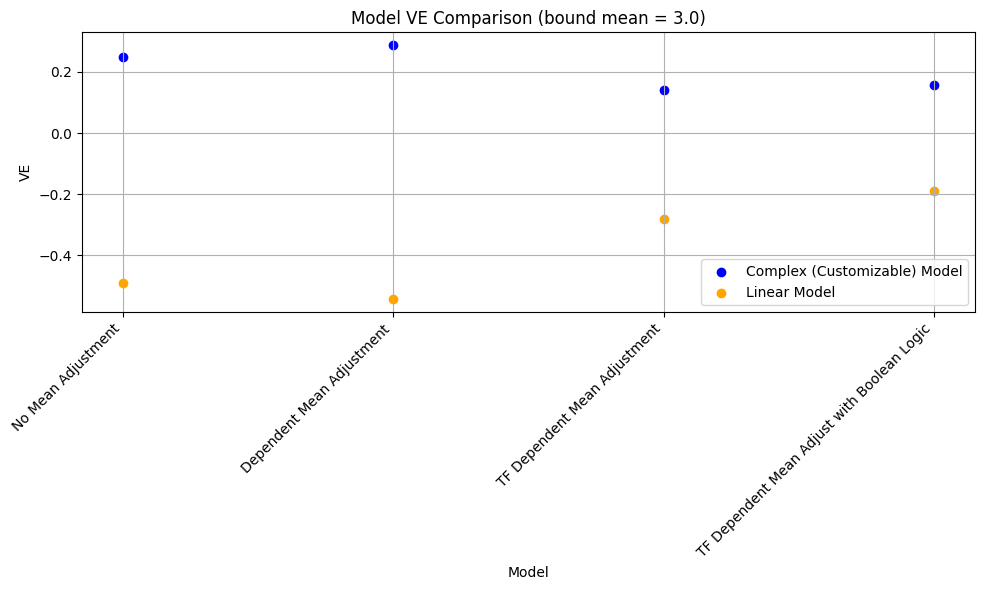

In [27]:
data_gen_methods = ["No Mean Adjustment", "Dependent Mean Adjustment", "TF Dependent Mean Adjustment", "TF Dependent Mean Adjust with Boolean Logic"]
plt.figure(figsize=(10, 6))
plt.scatter(data_gen_methods, model_ves, color='blue')
plt.scatter(data_gen_methods, linear_model_test_ves, color='orange')
plt.title('Model VE Comparison (bound mean = 3.0)')
plt.xlabel('Model')
plt.ylabel('VE')
plt.grid(True)
plt.xticks(rotation=45, ha="right")
plt.legend(['Complex (Customizable) Model', 'Linear Model'])
plt.tight_layout()  # Adjust layout to make room for the rotated x-axis labels
plt.show()

In [38]:
# imports
from yeastdnnexplorer.probability_models.generate_data import (
    generate_gene_population, 
    generate_binding_effects, 
    generate_pvalues, 
    generate_perturbation_effects
)

from yeastdnnexplorer.probability_models.util import (
    calculate_explained_variance
)

import torch
import matplotlib.pyplot as plt

from yeastdnnexplorer.probability_models.relation_classes import Relation, And, Or
from yeastdnnexplorer.probability_models.generate_data import (
    default_perturbation_effect_adjustment_function,
    perturbation_effect_adjustment_function_with_tf_relationships,
    perturbation_effect_adjustment_function_with_tf_relationships_boolean_logic
)

from pytorch_lightning import Trainer, seed_everything
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import explained_variance_score

from yeastdnnexplorer.data_loaders.synthetic_data_loader import SyntheticDataLoader
from yeastdnnexplorer.ml_models.simple_model import SimpleModel
from yeastdnnexplorer.ml_models.customizable_model import CustomizableModel

seed_everything(42)

n_genes = 3000
bound = [0.5, 0.5, 0.5, 0.5, 0.5]
n_sample = [1, 1, 2, 2, 4]

# Generate gene populations
gene_populations_list = []
for bound_proportion, n_draws in zip(bound, n_sample):
    for _ in range(n_draws):
        gene_populations_list.append(generate_gene_population(n_genes, bound_proportion))
        
# Generate binding data for each gene population
binding_effect_list = [generate_binding_effects(gene_population) for gene_population in gene_populations_list]

# Calculate p-values for binding data
binding_pvalue_list = [generate_pvalues(binding_data) for binding_data in binding_effect_list]

# Combine binding data into a tensor
binding_data_combined = [torch.stack((gene_population.labels, binding_effect, binding_pval), dim=1)
                         for gene_population, binding_effect, binding_pval in zip(gene_populations_list, binding_effect_list, binding_pvalue_list)]
binding_data_tensor = torch.stack(binding_data_combined, dim=1)

# TF relationships
tf_relationships = {
    0: [1],
    1: [8],
    2: [5, 6],
    3: [4],
    4: [5],
    5: [9],
    6: [4],
    7: [1, 4],
    8: [6],
    9: [4],
}

tf_relationships_dict_boolean_logic = {
    0: [And(3, 4, 8), Or(3, 7), Or(1, 1)],
    1: [And(5, Or(7, 8))],
    2: [],
    3: [Or(7, 9), And(6, 7)],
    4: [And(1, 2)],
    5: [Or(0, 1, 2, 8, 9)],
    6: [And(0, Or(1, 2))],
    7: [Or(2, And(5, 6, 9))],
    8: [],
    9: [And(6, And(3, Or(0, 9)))],
}

def experiment(n_iterations=10, GENE_IDX=0):
    print("Bound (1) and Unbound (0) Labels for gene " + str(GENE_IDX) + ":")
    print(binding_data_tensor[GENE_IDX, :, 0])

    num_tfs = sum(n_sample)
    
    no_mean_adjustment_scores = torch.zeros(num_tfs)
    normal_mean_adjustment_scores = torch.zeros(num_tfs)
    dep_mean_adjustment_scores = torch.zeros(num_tfs)
    boolean_logic_scores = torch.zeros(num_tfs)

    for i in range(n_iterations):
        # Method 1: Generate perturbation effects without mean adjustment
        perturbation_effects_list_no_mean_adjustment = [generate_perturbation_effects(binding_data_tensor[:, tf_index, :].unsqueeze(1), tf_index=0) 
                                                        for tf_index in range(num_tfs)]
        perturbation_effects_list_no_mean_adjustment = torch.stack(perturbation_effects_list_no_mean_adjustment, dim=1)

        # Method 2: Generate perturbation effects with normal mean adjustment
        perturbation_effects_list_normal_mean_adjustment = generate_perturbation_effects(
            binding_data_tensor, 
            max_mean_adjustment=10.0
        )

        # Method 3: Generate perturbation effects with dependent mean adjustment
        perturbation_effects_list_dep_mean_adjustment = generate_perturbation_effects(
            binding_data_tensor, 
            tf_relationships=tf_relationships,
            adjustment_function=perturbation_effect_adjustment_function_with_tf_relationships,
            max_mean_adjustment=10.0,
        )
        
        # Method 4: Generate perturbation effects with binary relations between the TFs
        perturbation_effects_list_boolean_logic = generate_perturbation_effects(
            binding_data_tensor, 
            adjustment_function=perturbation_effect_adjustment_function_with_tf_relationships_boolean_logic,
            tf_relationships=tf_relationships_dict_boolean_logic,
            max_mean_adjustment=10.0,
        )

        no_mean_adjustment_scores += abs(perturbation_effects_list_no_mean_adjustment[GENE_IDX, :])
        normal_mean_adjustment_scores += abs(perturbation_effects_list_normal_mean_adjustment[GENE_IDX, :])
        dep_mean_adjustment_scores += abs(perturbation_effects_list_dep_mean_adjustment[GENE_IDX, :])
        boolean_logic_scores += abs(perturbation_effects_list_boolean_logic[GENE_IDX, :])

        if (i + 1) % 5 == 0:
            print(f"iteration {i+1} completed")
        
    no_mean_adjustment_scores /= n_iterations
    normal_mean_adjustment_scores /= n_iterations
    dep_mean_adjustment_scores /= n_iterations
    boolean_logic_scores /= n_iterations
    
    return no_mean_adjustment_scores, normal_mean_adjustment_scores, dep_mean_adjustment_scores, boolean_logic_scores

GENE_IDX = 0
experiment_results = experiment(n_iterations=50, GENE_IDX=GENE_IDX)

def get_data_module(max_mean_adjustment, adjustment_function=default_perturbation_effect_adjustment_function, tf_relationships_dict={}):
    return SyntheticDataLoader(
        batch_size=32,
        num_genes=4000,
        bound_mean=3.0,
        bound=[0.5] * 5,
        n_sample=[1, 1, 2, 2, 4],
        val_size=0.1,
        test_size=0.1,
        random_state=42,
        max_mean_adjustment=max_mean_adjustment,
        adjustment_function=adjustment_function,
        tf_relationships=tf_relationships_dict,
    )

def get_model(num_tfs):
    return CustomizableModel(
        input_dim=num_tfs,
        output_dim=num_tfs,
        lr=0.01,
        hidden_layer_num=2,
        hidden_layer_sizes=[64, 32],
        activation="LeakyReLU",
        optimizer="RMSprop",
        L2_regularization_term=0.0,
        dropout_rate=0.0,
    )

def get_linear_model(num_tfs):
    return SimpleModel(
        input_dim=num_tfs,
        output_dim=num_tfs,
        lr=0.01
    )

def get_trainer():
    return Trainer(
        max_epochs=10,
        deterministic=True,
        accelerator="cpu",
    )

model_ves = []
linear_model_test_ves = []

Seed set to 42


Bound (1) and Unbound (0) Labels for gene 0:
tensor([0., 0., 0., 1., 1., 1., 1., 1., 0., 1.])
iteration 5 completed
iteration 10 completed
iteration 15 completed
iteration 20 completed
iteration 25 completed
iteration 30 completed
iteration 35 completed
iteration 40 completed
iteration 45 completed
iteration 50 completed


In [18]:
# Initialize data module
data_module = get_data_module(0.0)
num_tfs = sum(data_module.n_sample)

# --- Nonlinear Model ---
model = get_model(num_tfs)
trainer = get_trainer()
trainer.fit(model, data_module)
explained_variance = calculate_explained_variance(model, data_module)
model_ves.append(explained_variance)
print("Nonlinear Model Explained Variance:", explained_variance)

# --- Linear Model ---
linear_model = get_linear_model(num_tfs)
trainer = get_trainer()
trainer.fit(linear_model, data_module)
explained_variance_linear = calculate_explained_variance(linear_model, data_module)
linear_model_test_ves.append(explained_variance_linear)

print("Linear Model Explained Variance:", explained_variance_linear)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/ericjia/yeastdnnexplorer/yeastdnnexplorer/data_loaders/synthetic_data_loader.py:260: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train, Y_train = torch.tensor(X_train, dtype=torch.float32), torch.tensor(
/Users/ericjia/yeastdnnexplorer/yeastdnnexplorer/data_loaders/synthetic_data_loader.py:263: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_val, Y_val = torch.tensor(X_val, dtype=torch.float32), torch.tensor(
/Users/ericjia/yeastdnnexplorer/yeastdnnexplorer/data_loaders/synthetic_data_loader.py:266: UserWarning: To copy construct fr

Sanity Checking: |                                                                   | 0/? [00:00<?, ?it/s]

/Users/ericjia/yeastdnnexplorer/.venv/lib/python3.11/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 15 worker processes in total. Our suggested max number of worker in current system is 8 (`cpuset` is not taken into account), which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Training: |                                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                                        | 0/? [00:00<?, ?it/s]

Validation: |                                                                        | 0/? [00:00<?, ?it/s]

Validation: |                                                                        | 0/? [00:00<?, ?it/s]

Validation: |                                                                        | 0/? [00:00<?, ?it/s]

Validation: |                                                                        | 0/? [00:00<?, ?it/s]

Validation: |                                                                        | 0/? [00:00<?, ?it/s]

Validation: |                                                                        | 0/? [00:00<?, ?it/s]

Validation: |                                                                        | 0/? [00:00<?, ?it/s]

Validation: |                                                                        | 0/? [00:00<?, ?it/s]

Validation: |                                                                        | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/ericjia/yeastdnnexplorer/yeastdnnexplorer/data_loaders/synthetic_data_loader.py:260: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train, Y_train = torch.tensor(X_train, dtype=torch.float32), torch.tensor(
/Users/ericjia/yeastdnnexplorer/yeastdnnexplorer/data_loaders/synthetic_data_loader.py:263: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_val, Y_val = torch.tensor(X_val, dtype=torch.float32), torch.tensor(
/Users/ericjia/yeastdnnexplorer/yeastdnnexplorer/data_loaders/synthetic_data_

Nonlinear Model Explained Variance: 0.22300392389297485


Sanity Checking: |                                                                   | 0/? [00:00<?, ?it/s]

/Users/ericjia/yeastdnnexplorer/.venv/lib/python3.11/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 15 worker processes in total. Our suggested max number of worker in current system is 8 (`cpuset` is not taken into account), which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Training: |                                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                                        | 0/? [00:00<?, ?it/s]

Validation: |                                                                        | 0/? [00:00<?, ?it/s]

Validation: |                                                                        | 0/? [00:00<?, ?it/s]

Validation: |                                                                        | 0/? [00:00<?, ?it/s]

Validation: |                                                                        | 0/? [00:00<?, ?it/s]

Validation: |                                                                        | 0/? [00:00<?, ?it/s]

Validation: |                                                                        | 0/? [00:00<?, ?it/s]

Validation: |                                                                        | 0/? [00:00<?, ?it/s]

Validation: |                                                                        | 0/? [00:00<?, ?it/s]

Validation: |                                                                        | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


Linear Model Explained Variance: 0.005077654123306274


In [19]:
data_module = get_data_module(3.0)
num_tfs = sum(data_module.n_sample)

# Nonlinear model
model = get_model(num_tfs)
trainer = get_trainer()
trainer.fit(model, data_module)
explained_variance = calculate_explained_variance(model, data_module)
model_ves.append(explained_variance)
print("Nonlinear Model Explained Variance (Method 2):", explained_variance)

# Linear model
linear_model = get_linear_model(num_tfs)
trainer = get_trainer()
trainer.fit(linear_model, data_module)
explained_variance_linear = calculate_explained_variance(linear_model, data_module)
linear_model_test_ves.append(explained_variance_linear)
print("Linear Model Explained Variance (Method 2):", explained_variance_linear)


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/ericjia/yeastdnnexplorer/yeastdnnexplorer/data_loaders/synthetic_data_loader.py:260: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train, Y_train = torch.tensor(X_train, dtype=torch.float32), torch.tensor(
/Users/ericjia/yeastdnnexplorer/yeastdnnexplorer/data_loaders/synthetic_data_loader.py:263: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_val, Y_val = torch.tensor(X_val, dtype=torch.float32), torch.tensor(
/Users/ericjia/yeastdnnexplorer/yeastdnnexplorer/data_loaders/synthetic_data_loader.py:266: UserWarning: To copy construct fr

Sanity Checking: |                                                                   | 0/? [00:00<?, ?it/s]

/Users/ericjia/yeastdnnexplorer/.venv/lib/python3.11/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 15 worker processes in total. Our suggested max number of worker in current system is 8 (`cpuset` is not taken into account), which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Training: |                                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                                        | 0/? [00:00<?, ?it/s]

Validation: |                                                                        | 0/? [00:00<?, ?it/s]

Validation: |                                                                        | 0/? [00:00<?, ?it/s]

Validation: |                                                                        | 0/? [00:00<?, ?it/s]

Validation: |                                                                        | 0/? [00:00<?, ?it/s]

Validation: |                                                                        | 0/? [00:00<?, ?it/s]

Validation: |                                                                        | 0/? [00:00<?, ?it/s]

Validation: |                                                                        | 0/? [00:00<?, ?it/s]

Validation: |                                                                        | 0/? [00:00<?, ?it/s]

Validation: |                                                                        | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Nonlinear Model Explained Variance (Method 2): 0.2848140120506287


/Users/ericjia/yeastdnnexplorer/yeastdnnexplorer/data_loaders/synthetic_data_loader.py:260: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train, Y_train = torch.tensor(X_train, dtype=torch.float32), torch.tensor(
/Users/ericjia/yeastdnnexplorer/yeastdnnexplorer/data_loaders/synthetic_data_loader.py:263: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_val, Y_val = torch.tensor(X_val, dtype=torch.float32), torch.tensor(
/Users/ericjia/yeastdnnexplorer/yeastdnnexplorer/data_loaders/synthetic_data_loader.py:266: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor

Sanity Checking: |                                                                   | 0/? [00:00<?, ?it/s]

/Users/ericjia/yeastdnnexplorer/.venv/lib/python3.11/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 15 worker processes in total. Our suggested max number of worker in current system is 8 (`cpuset` is not taken into account), which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Training: |                                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                                        | 0/? [00:00<?, ?it/s]

Validation: |                                                                        | 0/? [00:00<?, ?it/s]

Validation: |                                                                        | 0/? [00:00<?, ?it/s]

Validation: |                                                                        | 0/? [00:00<?, ?it/s]

Validation: |                                                                        | 0/? [00:00<?, ?it/s]

Validation: |                                                                        | 0/? [00:00<?, ?it/s]

Validation: |                                                                        | 0/? [00:00<?, ?it/s]

Validation: |                                                                        | 0/? [00:00<?, ?it/s]

Validation: |                                                                        | 0/? [00:00<?, ?it/s]

Validation: |                                                                        | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


Linear Model Explained Variance (Method 2): 0.022074705362319945


In [20]:
# Method 3
tf_relationships_dict = {
    0: [1],
    1: [8],
    2: [5, 6],
    3: [4],
    4: [5],
    5: [9],
    6: [4],
    7: [1, 4],
    8: [6],
    9: [4],
}

data_module = get_data_module(3.0, perturbation_effect_adjustment_function_with_tf_relationships, tf_relationships_dict)
num_tfs = sum(data_module.n_sample)

# Nonlinear model
model = get_model(num_tfs)
trainer = get_trainer()
trainer.fit(model, data_module)
explained_variance = calculate_explained_variance(model, data_module)
model_ves.append(explained_variance)
print("Nonlinear Model Explained Variance (Method 3):", explained_variance)
#Nonlinear Model Explained Variance (Method 3): 0.1358485460281372
#Nonlinear Model Explained Variance (Method 3): 0.14976404905319213


# Linear model
linear_model = get_linear_model(num_tfs)
trainer = get_trainer()
trainer.fit(linear_model, data_module)
explained_variance_linear = calculate_explained_variance(linear_model, data_module)
linear_model_test_ves.append(explained_variance_linear)
print("Linear Model Explained Variance (Method 3):", explained_variance_linear)
#Linear Model Explained Variance (Method 3): -0.0013749837875366212


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/ericjia/yeastdnnexplorer/yeastdnnexplorer/data_loaders/synthetic_data_loader.py:260: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train, Y_train = torch.tensor(X_train, dtype=torch.float32), torch.tensor(
/Users/ericjia/yeastdnnexplorer/yeastdnnexplorer/data_loaders/synthetic_data_loader.py:263: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_val, Y_val = torch.tensor(X_val, dtype=torch.float32), torch.tensor(
/Users/ericjia/yeastdnnexplorer/yeastdnnexplorer/data_loaders/synthetic_data_loader.py:266: UserWarning: To copy construct fr

Sanity Checking: |                                                                   | 0/? [00:00<?, ?it/s]

/Users/ericjia/yeastdnnexplorer/.venv/lib/python3.11/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 15 worker processes in total. Our suggested max number of worker in current system is 8 (`cpuset` is not taken into account), which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Training: |                                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                                        | 0/? [00:00<?, ?it/s]

Validation: |                                                                        | 0/? [00:00<?, ?it/s]

Validation: |                                                                        | 0/? [00:00<?, ?it/s]

Validation: |                                                                        | 0/? [00:00<?, ?it/s]

Validation: |                                                                        | 0/? [00:00<?, ?it/s]

Validation: |                                                                        | 0/? [00:00<?, ?it/s]

Validation: |                                                                        | 0/? [00:00<?, ?it/s]

Validation: |                                                                        | 0/? [00:00<?, ?it/s]

Validation: |                                                                        | 0/? [00:00<?, ?it/s]

Validation: |                                                                        | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Nonlinear Model Explained Variance (Method 3): 0.1358485460281372


/Users/ericjia/yeastdnnexplorer/yeastdnnexplorer/data_loaders/synthetic_data_loader.py:260: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train, Y_train = torch.tensor(X_train, dtype=torch.float32), torch.tensor(
/Users/ericjia/yeastdnnexplorer/yeastdnnexplorer/data_loaders/synthetic_data_loader.py:263: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_val, Y_val = torch.tensor(X_val, dtype=torch.float32), torch.tensor(
/Users/ericjia/yeastdnnexplorer/yeastdnnexplorer/data_loaders/synthetic_data_loader.py:266: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor

Sanity Checking: |                                                                   | 0/? [00:00<?, ?it/s]

/Users/ericjia/yeastdnnexplorer/.venv/lib/python3.11/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 15 worker processes in total. Our suggested max number of worker in current system is 8 (`cpuset` is not taken into account), which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Training: |                                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                                        | 0/? [00:00<?, ?it/s]

Validation: |                                                                        | 0/? [00:00<?, ?it/s]

Validation: |                                                                        | 0/? [00:00<?, ?it/s]

Validation: |                                                                        | 0/? [00:00<?, ?it/s]

Validation: |                                                                        | 0/? [00:00<?, ?it/s]

Validation: |                                                                        | 0/? [00:00<?, ?it/s]

Validation: |                                                                        | 0/? [00:00<?, ?it/s]

Validation: |                                                                        | 0/? [00:00<?, ?it/s]

Validation: |                                                                        | 0/? [00:00<?, ?it/s]

Validation: |                                                                        | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


Linear Model Explained Variance (Method 3): -0.008052104711532592


In [21]:
# Method 4
data_module = get_data_module(
    3.0, 
    adjustment_function=perturbation_effect_adjustment_function_with_tf_relationships_boolean_logic, 
    tf_relationships_dict=tf_relationships_dict_boolean_logic
)
num_tfs = sum(data_module.n_sample)

# Nonlinear model
model = get_model(num_tfs)
trainer = get_trainer()
trainer.fit(model, data_module)
explained_variance = calculate_explained_variance(model, data_module)
model_ves.append(explained_variance)
print("Nonlinear Model Explained Variance (Method 4):", explained_variance)
#Nonlinear Model Explained Variance (Method 4): 0.12499817609786987

# Linear model
linear_model = get_linear_model(num_tfs)
trainer = get_trainer()
trainer.fit(linear_model, data_module)
explained_variance_linear = calculate_explained_variance(linear_model, data_module)
linear_model_test_ves.append(explained_variance_linear)
print("Linear Model Explained Variance (Method 4):", explained_variance_linear)
#Linear Model Explained Variance (Method 4): -0.013428604602813721

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/ericjia/yeastdnnexplorer/yeastdnnexplorer/data_loaders/synthetic_data_loader.py:260: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train, Y_train = torch.tensor(X_train, dtype=torch.float32), torch.tensor(
/Users/ericjia/yeastdnnexplorer/yeastdnnexplorer/data_loaders/synthetic_data_loader.py:263: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_val, Y_val = torch.tensor(X_val, dtype=torch.float32), torch.tensor(
/Users/ericjia/yeastdnnexplorer/yeastdnnexplorer/data_loaders/synthetic_data_loader.py:266: UserWarning: To copy construct fr

Sanity Checking: |                                                                   | 0/? [00:00<?, ?it/s]

/Users/ericjia/yeastdnnexplorer/.venv/lib/python3.11/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 15 worker processes in total. Our suggested max number of worker in current system is 8 (`cpuset` is not taken into account), which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Training: |                                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                                        | 0/? [00:00<?, ?it/s]

Validation: |                                                                        | 0/? [00:00<?, ?it/s]

Validation: |                                                                        | 0/? [00:00<?, ?it/s]

Validation: |                                                                        | 0/? [00:00<?, ?it/s]

Validation: |                                                                        | 0/? [00:00<?, ?it/s]

Validation: |                                                                        | 0/? [00:00<?, ?it/s]

Validation: |                                                                        | 0/? [00:00<?, ?it/s]

Validation: |                                                                        | 0/? [00:00<?, ?it/s]

Validation: |                                                                        | 0/? [00:00<?, ?it/s]

Validation: |                                                                        | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Nonlinear Model Explained Variance (Method 4): 0.14857358932495118


/Users/ericjia/yeastdnnexplorer/yeastdnnexplorer/data_loaders/synthetic_data_loader.py:260: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train, Y_train = torch.tensor(X_train, dtype=torch.float32), torch.tensor(
/Users/ericjia/yeastdnnexplorer/yeastdnnexplorer/data_loaders/synthetic_data_loader.py:263: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_val, Y_val = torch.tensor(X_val, dtype=torch.float32), torch.tensor(
/Users/ericjia/yeastdnnexplorer/yeastdnnexplorer/data_loaders/synthetic_data_loader.py:266: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor

Sanity Checking: |                                                                   | 0/? [00:00<?, ?it/s]

/Users/ericjia/yeastdnnexplorer/.venv/lib/python3.11/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 15 worker processes in total. Our suggested max number of worker in current system is 8 (`cpuset` is not taken into account), which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Training: |                                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                                        | 0/? [00:00<?, ?it/s]

Validation: |                                                                        | 0/? [00:00<?, ?it/s]

Validation: |                                                                        | 0/? [00:00<?, ?it/s]

Validation: |                                                                        | 0/? [00:00<?, ?it/s]

Validation: |                                                                        | 0/? [00:00<?, ?it/s]

Validation: |                                                                        | 0/? [00:00<?, ?it/s]

Validation: |                                                                        | 0/? [00:00<?, ?it/s]

Validation: |                                                                        | 0/? [00:00<?, ?it/s]

Validation: |                                                                        | 0/? [00:00<?, ?it/s]

Validation: |                                                                        | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


Linear Model Explained Variance (Method 4): -0.010988634824752808


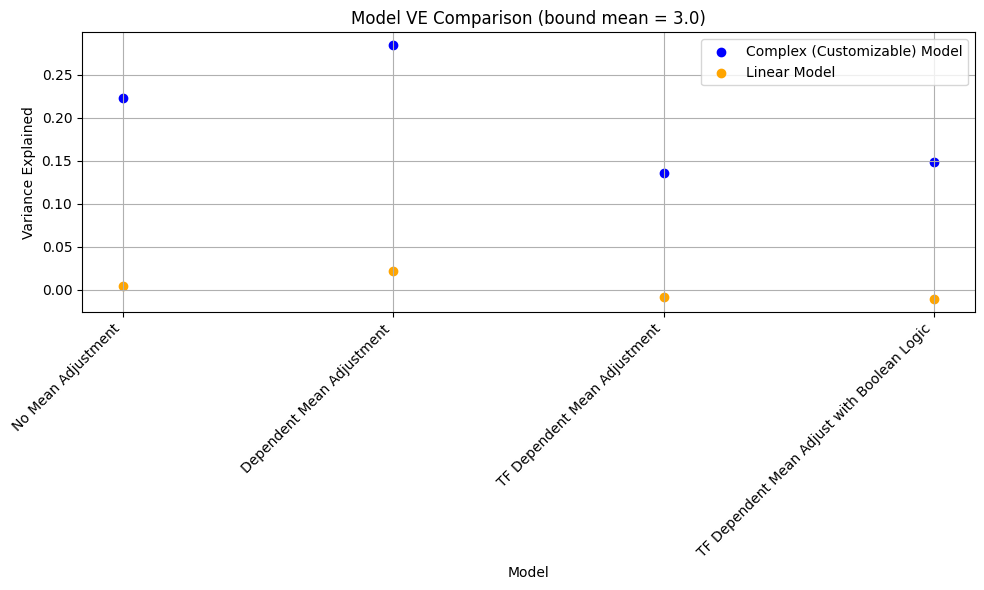

In [24]:
data_gen_methods = ["No Mean Adjustment", "Dependent Mean Adjustment", "TF Dependent Mean Adjustment", "TF Dependent Mean Adjust with Boolean Logic"]
plt.figure(figsize=(10, 6))
plt.scatter(data_gen_methods, model_ves, color='blue')
plt.scatter(data_gen_methods, linear_model_test_ves, color='orange')
plt.title('Model VE Comparison (bound mean = 3.0)')
plt.xlabel('Model')
plt.ylabel('Variance Explained')
plt.grid(True)
plt.xticks(rotation=45, ha="right")
plt.legend(['Complex (Customizable) Model', 'Linear Model'])
plt.tight_layout()
plt.show()